# Cryptocurrency prediction deep learning

### Predicción del precio de cryptomonedas con deep learning

"Projecto" : "Análisis_criptomonedas"  
"Título" : "Predicción del precio de cryptomonedas con deep learning"  
"Autor" : "Cristian García Díaz"  
"Fecha de creación" : "20180821"  
"Fecha de modificación" : "20180826"  
"Fuentes":
>#### Network  
>https://medium.com/activewizards-machine-learning-company/bitcoin-price-forecasting-with-deep-learning-algorithms-eb578a2387a3

## Índice
[1. Configuración del entorno](#1)  
[2. Obtención y almacenamiento de los datos](#2)  
[3. Análisis, procesado de los datos y visualización de los datos](#3)  
[4. Predicción aplicando redes neuronales](#4) 

## <a name="1"></a> 1. Configuración del entorno

   - Importar funciones y librerías necesarias    

In [1]:
#Se importan las librerias necesarias
#Gestión de archivos y datos
import os
from datetime import datetime
import pickle
from time import time

#Gráficas
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import statsmodels.api as sm

from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from random import randint

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.callbacks import EarlyStopping
from keras import initializers

from matplotlib import pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go

# Se configura el modo offline
py.init_notebook_mode(connected=True)
%matplotlib inline

Using TensorFlow backend.


## <a name="2"></a> 2. Obtención y almacenamiento de los datos

   - Importar funciones y librerías necesaria.
   - Función para obtener los datos.
   - Almacenar los datos en ficheros.

In [2]:
# Comprobar si no esta creada la carpeta de archivos para almacenar los datos
directorio = "cryptocurrency_analysis_files"
if not os.path.exists(directorio):
    os.mkdir(directorio)

In [3]:
#Se añaden los datos de Bitcoin
# Se define una función get_json_data para cargar los datos de la API Poloniex
"""pickle --> para no descargar de nuevo los mismo datos"""
"""La función devuelve un Dataframe Pandas"""

def get_json_data(json_url,cache_path):
    cache_path = directorio +'\{}.pkl'.format(cache_path)
    """Descargamos en cache los datos en formato json"""
    try:
        f = open(cache_path,'rb')
        df = pickle.load(f)
        print('Dataset {} cargado del cache'.format(json_url))
    except (OSError,IOError) as e:
        print('Descargando datos {} mediante la API Poloniex'.format(json_url))
        df = pd.read_json(json_url)
        df.to_pickle(cache_path)
        print('Cargado {} de {} en el cache'.format(json_url,cache_path))
    return df

In [4]:
# Se define la función genera las peticiones vía HTTP a Poloniex API y se llamará a la función get_json_data para guardar los datos obtenidos
base_url = 'https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period={}'
start_date = datetime.strptime('2015-01-01', '%Y-%m-%d')
end_date = datetime.now()
# Periodos válidos: '15m': 900, '5m': 300, '30m': 1800, '4h': 14400, '2h': 7200, '1d': 86400
period = 86400

def get_crypto_data(poloniex_pair):
    '''Captura de los datos de criptomonedas de la API Poliniex'''
    json_url = base_url.format(poloniex_pair,start_date.timestamp(),end_date.timestamp(),period)
    data_df = get_json_data(json_url,poloniex_pair)
    data_df = data_df.set_index('date')
    return data_df

# URL de ejemplo: https://poloniex.com/public?command=returnChartData&currencyPair=BTC_ETH&start=1420066800.0&end=1483225200.0&period=86400

In [5]:
# Diccionario altcoins formado por un dataframe por cada criptomoneda.
# Cada dataframe contiene el ratio medio de cammbio entre altcoins y BTC.
#altcoins = ['ETH','LTC','XRP','ETC','STR','DASH','SC','XMR','XEM']
altcoins = ['BTC']

altcoin_data = {}
for altcoin in altcoins:
    coinpair = 'USDT_{}'.format(altcoin)
    
    BTC_price_real_df = get_crypto_data(coinpair)
    altcoin_data[altcoin] = BTC_price_real_df

Dataset https://poloniex.com/public?command=returnChartData&currencyPair=USDT_BTC&start=1420066800.0&end=1535476612.806668&period=86400 cargado del cache


## <a name="3"></a> 3. Análisis, procesado de los datos y visualización de los datos

   - Función para visualizar los datos.
   - Visualizar los datos.

In [6]:
# Se define la función para visualizar los datos
def df_scatter(df, title,seperate_y_axis=False, y_axis_label='',scale='linear',initial_hide=False):
    # Se definen la lista de los nombres de cada dataframe como una lista label_arr = ['BITSTAMP', 'COINBASE', 'ITBIT', 'KRAKEN']
    label_arr = list(df)
    # Aplicamos una función lambda para mapear cada columnas y asignar la etiqueta correspondiente
    # Se guarda como otra lista series_arr
    series_arr = list(map(lambda col:df[col],label_arr))
    
    # Se definen los parametros de la salida gráfica
    layout = go.Layout(
        title = title,
        legend = dict(orientation='h'),
        xaxis = dict(type='date'),
        yaxis = dict(
            title = y_axis_label, 
            showticklabels = not seperate_y_axis,
            type = scale
        )
    )
    
    # Se define la configuración del eje y
    y_axis_config = dict(
        overlaying = 'y',
        showticklabels = False,
        type = scale
    )
    
    # Se define la visibilidad
    visibility = 'visible'
    if initial_hide:
        visibility = 'legendonly'
        
    # Se define la forma para cada serie de datos
    trace_arr = []
    for index, series in enumerate(series_arr):
        trace = go.Scatter(
        x = series.index,
        y = series,
        name = label_arr[index],
        visible = visibility
        )
        
        #Añadir un eje separado para cada serie
        if seperate_y_axis:
            trace['yaxis'] = 'y{format}'.format(index + 1)
            layout['yaxis{}'.format(index + 1)] = y_axis_config
        trace_arr.append(trace)
    
    fig = go.Figure(data = trace_arr, layout = layout)
    py.iplot(fig)

In [7]:
BTC_price_real_df.head()

,close,high,low,open,quoteVolume,volume,weightedAverage
date,,,,,,,
2015-02-19,244.00,244.000,225.00,225.000000,0.193117,46.276313,239.627778
2015-02-20,240.25,245.000,240.25,240.250118,0.230429,55.894897,242.568479
2015-02-21,245.00,245.000,245.00,245.000000,0.060091,14.722239,245.000000
2015-02-22,235.00,249.000,235.00,245.000000,0.539055,129.121248,239.532608
2015-02-23,235.00,235.001,235.00,235.000002,0.410926,96.567562,235.000062


In [8]:
BTC_price_real_df.tail()

,close,high,low,open,quoteVolume,volume,weightedAverage
date,,,,,,,
2018-08-22,6354.767602,6894.597094,6255.608559,6479.132290,2172.958589,1.429791e+07,6579.926417
2018-08-23,6530.616799,6567.216243,6344.410970,6354.767602,592.459626,3.817506e+06,6443.486423
2018-08-24,6685.522183,6718.000000,6458.002476,6525.836537,759.907347,4.998491e+06,6577.763106
2018-08-25,6726.091103,6789.000000,6665.000000,6693.306879,519.285013,3.486018e+06,6713.112009
2018-08-26,6672.484700,6778.395678,6571.297810,6726.258293,449.810054,2.998773e+06,6666.755151


In [9]:
# Gráfico del precio del BTC
btc_trace = go.Scatter(x=BTC_price_real_df.index, y=BTC_price_real_df['close'])
py.iplot([btc_trace])

In [10]:
# Se llama a la función df_scatter para mostrar los precios BTC de los exchanges
df_scatter(BTC_price_real_df[['close','open']], 'Precio BTC (USD)')
#BTC_price_real_df[['open','close']]

In [11]:
# Se llama a la función df_scatter para mostrar los precios BTC de los exchanges
df_scatter(BTC_price_real_df[['open','close','low','high']], 'Precio BTC (USD)')

In [12]:
#Estadísticas básicas de los datos
BTC_price_real_df.describe()

,close,high,low,open,quoteVolume,volume,weightedAverage
count,1285.000000,1285.000000,1285.000000,1285.000000,1285.000000,1.285000e+03,1285.000000
mean,2941.746722,3047.614370,2807.182721,2936.935794,3376.588062,1.627160e+07,2927.950550
std,3852.003605,4023.559003,3632.777664,3851.519821,5947.444633,3.375669e+07,3825.900868
min,178.719313,219.010000,99.000000,191.300000,0.000000,0.000000e+00,207.450144
25%,403.841623,415.018697,384.332000,399.000004,29.182476,1.136105e+04,403.318716
50%,743.426553,755.000000,728.289801,742.359480,691.344328,6.215580e+05,739.531856
75%,4787.657550,4900.000000,4664.633844,4770.000000,4504.282267,1.831713e+07,4789.414434
max,19223.000000,19903.440214,18569.637853,19223.000000,48896.616808,3.960385e+08,19236.130652


## <a name="4"></a> 4. Predicción aplicando redes neuronales

   - Visualizar los datos.
   - Transformación de los datos
   - Aplicar las redes neuronales
   - Visualizar los resultados
   - Calcular errores
   
  
   >https://machinelearningmastery.com/stacked-long-short-term-memory-networks/

In [13]:
#Copiamos los datos a un DF nuevo para poder trabajar con él sin afectar a los datos originales
BTC_price_transform = BTC_price_real_df

In [14]:
# Comprobamos si hay datos que sean nulos en cualquier lugar del DF
# Estamos de suerte no hay datos nulos
BTC_price_transform.isnull().any()

close              False
high               False
low                False
open               False
quoteVolume        False
volume             False
weightedAverage    False
dtype: bool

In [15]:
# Cantidad de observaciones
BTC_price_transform.shape

(1285, 7)

In [16]:
#Cogemos el precio medio de Bitcoin para realizar el análisis
BTC_daily_price = BTC_price_transform['weightedAverage']

In [17]:
BTC_daily_price.head()

date
2015-02-19    239.627778
2015-02-20    242.568479
2015-02-21    245.000000
2015-02-22    239.532608
2015-02-23    235.000062
Name: weightedAverage, dtype: float64

In [18]:
BTC_daily_price.tail()

date
2018-08-22    6579.926417
2018-08-23    6443.486423
2018-08-24    6577.763106
2018-08-25    6713.112009
2018-08-26    6666.755151
Name: weightedAverage, dtype: float64

In [19]:
# Estadísticas básicas del precio
BTC_daily_price.describe()

count     1285.000000
mean      2927.950550
std       3825.900868
min        207.450144
25%        403.318716
50%        739.531856
75%       4789.414434
max      19236.130652
Name: weightedAverage, dtype: float64

In [20]:
# Forma del Dataframe
BTC_price_transform.shape

(1285, 7)

In [21]:
# Preparación para partir el Dataframe para obtener los datos para entrenanmiento y para el test
# Días totales
d0 = datetime(2016, 11, 2)
d1 = datetime(2018, 8, 17)
#
#d0 = datetime(2015, 2, 20)
#d1 = datetime(2018, 8, 17)
delta = d1 - d0
days_look = delta.days + 1
print(days_look)

d0 = datetime(2018, 6, 23)
d1 = datetime(2018, 8, 22)
#d0 = datetime(2018, 6, 23)
#d1 = datetime(2018, 8, 22)
delta = d1 - d0
days_from_train = delta.days + 1
print(days_from_train)

d0 = datetime(2018, 8, 17)
d1 = datetime(2018, 8, 22)
#d0 = datetime(2018, 8, 17)
#d1 = datetime(2018, 8, 22)
delta = d1 - d0
days_from_end = delta.days + 1
print(days_from_end)

# 1275 61 6 --> RSM 641.125
# 654 61 6 --> RSM 214.927
# 654 61 6 --> RSM 193.449

654
61
6


In [25]:
# Separar en Dataframe los modelos de entreno y de test

# df_train= BTC_daily_price[len(BTC_daily_price)-days_look-days_from_end
#                          :len(BTC_daily_price)-days_from_train]
# df_train= BTC_daily_price[Desde -->1285 total de días -  654 días mirados - 6 dias hasta el final
#                           Hasta -->:1285 total de días - 61 días desde el entreno]
# 599 días de entreno
df_train= BTC_daily_price[len(BTC_daily_price)-days_look-days_from_end:len(BTC_daily_price)-days_from_train]

# df_test = BTC_daily_price[len(BTC_daily_price)-days_from_train:]
#                           
# df_test = BTC_daily_price[Desde --> 1285 total de días - 61 días desde el entreno:
#                           Hasta --> Final]
# 61 días de test
df_test= BTC_daily_price[len(BTC_daily_price)-days_from_train:]

print(len(df_train), len(df_test))

599 61


In [26]:
print(len(BTC_daily_price)-days_look-days_from_end,len(BTC_daily_price)-days_from_train)
print(len(BTC_daily_price),-days_look-days_from_end,len(BTC_daily_price),-days_from_train)
print(len(BTC_daily_price)-days_from_train)
print(len(BTC_daily_price),-days_from_train)

625 1224
1285 -660 1285 -61
1224
1285 -61


In [27]:
df_train

date
2016-11-05     706.731912
2016-11-06     712.901448
2016-11-07     705.657948
2016-11-08     710.551798
2016-11-09     729.519048
2016-11-10     716.922791
2016-11-11     717.364989
2016-11-12     707.906868
2016-11-13     694.271747
2016-11-14     704.512848
2016-11-15     712.418305
2016-11-16     734.874884
2016-11-17     746.230601
2016-11-18     746.842530
2016-11-19     752.160213
2016-11-20     736.389709
2016-11-21     737.455427
2016-11-22     742.560453
2016-11-23     740.845351
2016-11-24     736.072088
2016-11-25     736.499169
2016-11-26     732.672530
2016-11-27     733.306066
2016-11-28     732.315227
2016-11-29     732.177748
2016-11-30     737.703313
2016-12-01     749.488259
2016-12-02     768.914130
2016-12-03     765.858334
2016-12-04     768.011682
                 ...     
2018-05-28    7216.749870
2018-05-29    7332.908266
2018-05-30    7421.729984
2018-05-31    7515.594375
2018-06-01    7467.204236
2018-06-02    7618.623509
2018-06-03    7697.780274
2018-06

In [28]:
df_train.tail()

date
2018-06-22    6187.652025
2018-06-23    6120.536737
2018-06-24    5926.860402
2018-06-25    6216.814384
2018-06-26    6169.845945
Name: weightedAverage, dtype: float64

In [29]:
df_test.head()

date
2018-06-27    6075.170946
2018-06-28    5984.767846
2018-06-29    5948.481903
2018-06-30    6383.413400
2018-07-01    6367.900552
Name: weightedAverage, dtype: float64

In [30]:
df_test.tail()

date
2018-08-22    6579.926417
2018-08-23    6443.486423
2018-08-24    6577.763106
2018-08-25    6713.112009
2018-08-26    6666.755151
Name: weightedAverage, dtype: float64

In [23]:
# Para estimar los parametros de nuestros datos porque podrían ser útiles para modelos posteriores.
# Si se quieren predecir los datos hau que comprobar si los datos son estacionarios.
# Si trienen factores de estacionalidad o tendencia.
working_data = [df_train, df_test]
working_data = pd.concat(working_data)

working_data = working_data.reset_index()
working_data['date'] = pd.to_datetime(working_data['date'])
working_data = working_data.set_index('date')

In [24]:
# Comprobamos los datos
working_data.count()

weightedAverage    660
dtype: int64

In [25]:
# Se realiza una descomposición estacional de los datos para estimar su tendencia y estacionalidad.
# Puede ver los movimientos reales de los precios en el gráfico de abajo ("observados"), así como la tendencia
# y estacionalidad de nuestros datos.

s = sm.tsa.seasonal_decompose(working_data.weightedAverage.values, freq=60)

trace1 = go.Scatter(x = np.arange(0, len(s.trend), 1),y = s.trend,mode = 'lines',name = 'Tendencia',
    line = dict(color = ('rgb(244, 146, 65)'), width = 4))
trace2 = go.Scatter(x = np.arange(0, len(s.seasonal), 1),y = s.seasonal,mode = 'lines',name = 'Estacionalidad',
    line = dict(color = ('rgb(66, 244, 155)'), width = 2))
trace3 = go.Scatter(x = np.arange(0, len(s.resid), 1),y = s.resid,mode = 'lines',name = 'Residuos',
    line = dict(color = ('rgb(209, 244, 66)'), width = 2))
trace4 = go.Scatter(x = np.arange(0, len(s.observed), 1),y = s.observed,mode = 'lines',name = 'Observaciones',
    line = dict(color = ('rgb(66, 134, 244)'), width = 2))

data = [trace1, trace2, trace3, trace4]
layout = dict(title = 'Descomposición estacional', xaxis = dict(title = 'Tiempo'), yaxis = dict(title = 'Precio en USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='Descomposición estacional')


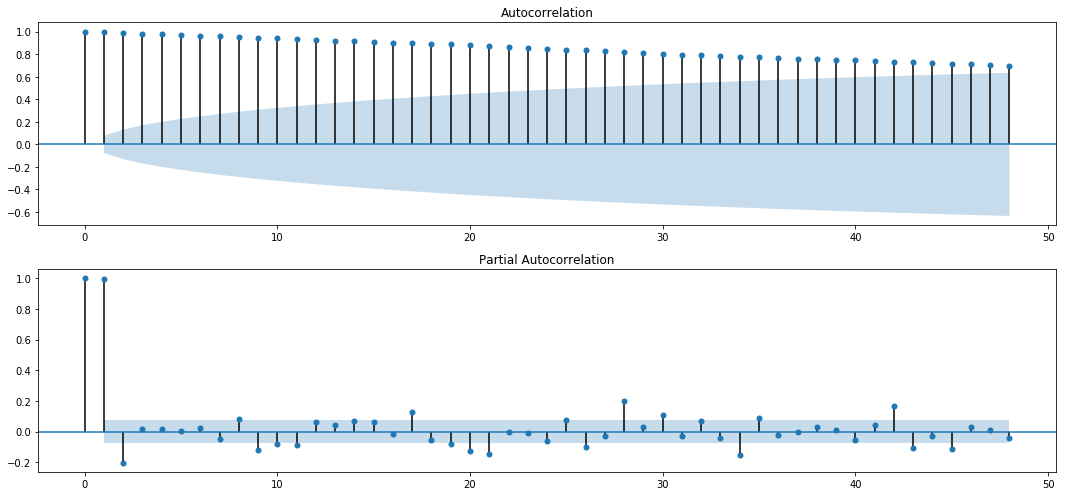

In [26]:
# Ahora realizaremos una autocorrelación para comprobar la similitud entre las observaciones en función al desfase temporal.
# Se pueden encontrar patrones repetitivos en los datos de esta forma.
#1º deribada
#2º deribada
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(working_data.weightedAverage.values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(working_data.weightedAverage.values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

In [27]:
# Se vuelve al estado inicial
days_from_train_input=days_from_train-1
df_train = working_data[:-days_from_train_input]
df_test = working_data[-days_from_train_input:]

In [28]:
# Información
df_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 600 entries, 2016-11-05 to 2018-06-27
Data columns (total 1 columns):
weightedAverage    600 non-null float64
dtypes: float64(1)
memory usage: 9.4 KB


In [29]:
# Se prepara el dataset de acuerdo a los requerimientos del modelo y dividir el conjunto de datos en entrenamiento y prueba.
# Se define la función que crea X e Y etiquetas para el modelo.
# En la predicción secuencial se predicen valores futuros en función de valores anterior y actuales.
# Por tanto, la etiqueta Y es el siguiente punto futuro, mientras que las entradas X son los valores del pasado.
# La cantidad de los valores lo podemos establecer modificadndo el parametro look_back.
# Si look_back=1 entonces se predice el valor actual t basado en el valor anterior (t-1)
# Se convierte el vector en una matriz de valores futuros
# Para cada valor se coge el historico y se vuelve a crear un valor con el valor futuro.
def create_lookback(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [30]:
# Funcionamiento de la función loock_back
#prueba = training_set[0:4]
#X, Y = [], []
#for i in range(len(prueba) - look_back):
#    a = prueba[i:(i + look_back), 0]
#    X.append(a)
#    Y.append(prueba[i + look_back, 0])
#    print('posición:',i,':X-->',X,' Y -->', Y)

In [31]:
# Se rescalan los valores del Dataframe
training_set = df_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
test_set = df_test.values
test_set = np.reshape(test_set, (len(test_set), 1))

# Se escala el Dataframe para el modelo 
# El rescalado se realiza con MinMaxScaler() -->  http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
# Aplicando
# X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
# X_scaled = X_std * (max - min) + min

scaler = MinMaxScaler()
training_set = scaler.fit_transform(training_set)
test_set = scaler.transform(test_set)

In [32]:
# Se crean los conjuntos de datos necesarios para la previsión de series temporales
look_back = 1
X_train, Y_train = create_lookback(training_set, look_back)
X_test, Y_test = create_lookback(test_set, look_back)

In [33]:
# X_train


In [34]:
# Y_train

In [35]:
# X_test

In [36]:
# Y_test

In [37]:
# Se remodelan los conjuntos de datos con la estructura necesaria para los requisitos del modelo LSTM en Keras
X_train = np.reshape(X_train, (len(X_train), 1, X_train.shape[1]))
X_test = np.reshape(X_test, (len(X_test), 1, X_test.shape[1]))

In [38]:
# X_train

In [39]:
# X_test

In [40]:
# Se utiliza el framework de keras. El modelo aplicado es do capas Long Short-Term Memory network apiladas con 256 neuronas cada una.
# La capa de salida esta densamente conectada a una neurona. Se utiliza optimizador Adam y MSE como una pérdida.
# Se utiliza una parada anticipada si el resultado no mejora a las 20 iteraciones.
# El tamaño óptimo es de 100 y 16 iteraciones, respectivamente.
# Además es importante establecer suffle = fals pra no mezclar los datos de serie temporal.

# Inicialización del modelo secuencial, se añaden 2 capas LSTM apiladas y densamente conectadas a la neurona de salida
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(256))
model.add(Dense(1, activation='sigmoid'))

# Comprobar el tiempo
start_time = time()
# Compilación y ajuste del modelo
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, Y_train, epochs=100, batch_size=16, shuffle=False,
    validation_data=(X_test, Y_test),
    callbacks = [EarlyStopping(monitor='val_loss', min_delta=5e-5, patience=20, verbose=1)])

# Comprobar el tiempo
final_time = time() - start_time

Train on 599 samples, validate on 59 samples
Epoch 1/100
599/599 [==============================] - 6s 10ms/step - loss: 0.1117 - val_loss: 0.0064
Epoch 2/100
599/599 [==============================] - 2s 4ms/step - loss: 0.0840 - val_loss: 0.0013
Epoch 3/100
599/599 [==============================] - 2s 3ms/step - loss: 0.0552 - val_loss: 0.0010
Epoch 4/100
599/599 [==============================] - 2s 3ms/step - loss: 0.0379 - val_loss: 4.3725e-04
Epoch 5/100
599/599 [==============================] - 2s 4ms/step - loss: 0.0205 - val_loss: 3.3680e-04
Epoch 6/100
599/599 [==============================] - 2s 4ms/step - loss: 0.0077 - val_loss: 1.0625e-04
Epoch 7/100
599/599 [==============================] - 2s 4ms/step - loss: 0.0028 - val_loss: 4.4338e-04
Epoch 8/100
599/599 [==============================] - 2s 4ms/step - loss: 0.0019 - val_loss: 6.2429e-04
Epoch 9/100
599/599 [==============================] - 2s 4ms/step - loss: 0.0018 - val_loss: 6.7439e-04
Epoch 10/100
599/599 

In [41]:
# Tiempo de ejecución
print('Tiempo de ejecución de la red neural es de: {0:.3f}'.format(final_time))

Tiempo de ejecución de la red neural es de: 70.283


In [42]:
# Visualización de las pérdidas de test y entreno
trace1 = go.Scatter(
    x = np.arange(0, len(history.history['loss']), 1),
    y = history.history['loss'],
    mode = 'lines',
    name = 'Train loss',
    line = dict(color=('rgb(66, 244, 155)'), width=2, dash='dash')
)
trace2 = go.Scatter(
    x = np.arange(0, len(history.history['val_loss']), 1),
    y = history.history['val_loss'],
    mode = 'lines',
    name = 'Test loss',
    line = dict(color=('rgb(244, 146, 65)'), width=2)
)

data = [trace1, trace2]

layout = dict(title = 'Train and Test Loss during training',
              xaxis = dict(title = 'Epoch number'), yaxis = dict(title = 'Loss'))

fig = dict(data=data, layout=layout)

py.iplot(fig, filename='training_process')

In [43]:
# Se ha entranado al modelo y se pude ver un buen rendimiento despues de unas iteracciones.
# En este gráfico podemos comparar  las perdidas en el entreno y en el test.
# Despues de unas iteraciones las perdidas se vuelven prácticamente igual lo que quiere decir que evitamos el sobreajuste.
# Ahora se utiliza el modelo para predecir los datos del test.
# Luego comparamos los datos de las etiquetas verdaderas y las pronosticadas.

X_test = np.append(X_test, scaler.transform(working_data.iloc[-1][0]))
X_test = np.reshape(X_test, (len(X_test), 1, 1))

# Se obtienen las predicciones y se hacen las transformaciones para calcular en RMSE en USD
prediction = model.predict(X_test)
prediction_inverse = scaler.inverse_transform(prediction.reshape(-1, 1))
Y_test_inverse = scaler.inverse_transform(Y_test.reshape(-1, 1))
prediction2_inverse = np.array(prediction_inverse[:,0][1:])
Y_test2_inverse = np.array(Y_test_inverse[:,0])

In [44]:
# Visualización de 
trace1 = go.Scatter(
    x = np.arange(0, len(prediction2_inverse), 1),
    y = prediction2_inverse,
    mode = 'lines',
    name = 'Predicted labels',
    line = dict(color=('rgb(244, 146, 65)'), width=2)
)
trace2 = go.Scatter(
    x = np.arange(0, len(Y_test2_inverse), 1),
    y = Y_test2_inverse,
    mode = 'lines',
    name = 'True labels',
    line = dict(color=('rgb(66, 244, 155)'), width=2)
)

data = [trace1, trace2]
layout = dict(title = 'Comparison of true prices (on the test dataset) with prices our model predicted',
             xaxis = dict(title = 'Day number'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='results_demonstrating0')

In [45]:
# Ahora se muestra el indicador RMSE que muestra el error. Podemos ver que el número es de unos 214 USD.
# Root Mean Square Error
RMSE = sqrt(mean_squared_error(Y_test2_inverse, prediction2_inverse))
print('Test RMSE: %.3f' % RMSE)

Test RMSE: 177.861


In [46]:
# Porcentaje del RSME respecto al rango de los datos estudiados
Porcentaje = RMSE/(Y_test2_inverse.max()-Y_test2_inverse.min())*100
print('El porcentaje respecto a la variación del precio actual es: {0:.3f} %'.format(Porcentaje))

El porcentaje respecto a la variación del precio actual es: 7.746 %


In [47]:
# Función que calcula el SMAPE
# Symmetric Mean Absolute Percentage Error
from numba import jit
import math

def smape_fast(y_true, y_pred):
    out = 0
    for i in range(y_true.shape[0]):
        a = y_true[i]
        b = y_pred[i]
        c = a+b
        if c == 0:
            continue
        out += math.fabs(a - b) / c
    out *= (200.0 / y_true.shape[0])
    return out

out=smape_fast(Y_test2_inverse,prediction2_inverse)

print('SMAPE: {0:.3f}'.format(out) )

SMAPE: 2.508


In [48]:
# Ahora se extrae con el formato de fechas y se traza 
Test_Dates = BTC_daily_price[len(BTC_daily_price)-days_from_train:].index

trace1 = go.Scatter(x=Test_Dates, y=Y_test2_inverse, name= 'Actual Price',
                   line = dict(color = ('rgb(66, 244, 155)'),width = 2))
trace2 = go.Scatter(x=Test_Dates, y=prediction2_inverse, name= 'Predicted Price',
                   line = dict(color = ('rgb(244, 146, 65)'),width = 2))
data = [trace1, trace2]
layout = dict(title = 'Comparison of true prices (on the test dataset) with prices our model predicted, by dates',
             xaxis = dict(title = 'Date'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='results_demonstrating1')

In [49]:
# Estos resultados se pueden mejorar. Se obtiene 10 conjuntos de datos de entreno y test diferentes.
# Despues se calcula el RMSE para cada conjunto entreno/test para despues obtener el RSME promedio.

# Función para separar de forma aleatorio en conjunto de datos entreno/prueba
# Escalar los datos con MinMaxScaler y crear las etiquetas de series temporales.

def get_split(working_data, n_train, n_test, look_back = 1):
    # de un punto dado aleatorio obtener el conjunto de entreno y el de test.
    # get a point from which we start to take train dataset and after it - test dataset
    start_point = randint(0, (len(working_data)-n_test-n_train))
    df_train = working_data[start_point:start_point+n_train]
    df_test = working_data[start_point+n_train:start_point+n_train+n_test]

    training_set = df_train.values
    training_set = np.reshape(training_set, (len(training_set), 1))
    test_set = df_test.values
    test_set = np.reshape(test_set, (len(test_set), 1))

    # Escalar los datasets
    scaler_cv = MinMaxScaler()
    training_set = scaler_cv.fit_transform(training_set)
    test_set = scaler_cv.transform(test_set)

    # Crear los datasets adecuados para la estimación de las series temporales
    X_train, Y_train = create_lookback(training_set, look_back)
    X_test, Y_test = create_lookback(test_set, look_back)

    # Remodelado de los datasets para los requisitos de los modelos en Keras
    X_train = np.reshape(X_train, (len(X_train), 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (len(X_test), 1, X_test.shape[1]))

    return X_train, Y_train, X_test, Y_test, scaler_cv, start_point

# Función que toma como datos de entreno los datos de entreno
def train_model(X_train, Y_train, X_test, Y_test):
    # Inicializar el model secuencial y bidireccional de la capa LSTM y conectada densamente a la neurona de salida 
    model = Sequential()
    model.add(GRU(256, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))

    # Compilar y ajustar el modelo
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, Y_train, epochs = 100, batch_size = 16, shuffle = False,
                    validation_data=(X_test, Y_test), verbose=0,
                    callbacks = [EarlyStopping(monitor='val_loss',min_delta=5e-5,patience=20,verbose=0)])
    return model

# Función que calcula el modelo entrenado y el de test ara calcular el RSME
def get_rmse(model, X_test, Y_test, scaler, start_point, working_data, n_train):
    # Aliniar las formas de las predicciones
    X_test = np.append(X_test, scaler.transform(working_data.iloc[start_point+n_train+len(X_test)][0]))
    X_test = np.reshape(X_test, (len(X_test), 1, 1))

    # obtener las predicciones y luefo hacer algunas transformaciones para poder calcular RMSE correctamente en USD
    prediction = model.predict(X_test)
    prediction_inverse = scaler.inverse_transform(prediction.reshape(-1, 1))
    Y_test_inverse = scaler.inverse_transform(Y_test.reshape(-1, 1))
    prediction2_inverse = np.array(prediction_inverse[:,0][1:])
    Y_test2_inverse = np.array(Y_test_inverse[:,0])

    # Calcular RMSE
    RMSE = sqrt(mean_squared_error(Y_test2_inverse, prediction2_inverse))
    return RMSE, prediction2_inverse

In [50]:
# Función que utiliza las funciones anteriores para crear el flujo de trabajo
# con los calculos y devuelve el RSME y las predicciones
def workflow(working_data, get_split, train_model, get_rmse,n_train = 250,n_test = 50,look_back = 1):
    X_train, Y_train, X_test, Y_test, scaler, start_point = get_split(working_data, n_train, n_test)
    model = train_model(X_train, Y_train, X_test, Y_test)
    RMSE, predictions = get_rmse(model, X_test, Y_test, scaler, start_point, working_data, n_train)
    return RMSE, predictions

In [51]:
# Función que calcula RSM para un modelo GRU
RMSE, predictions = workflow(working_data, get_split, train_model, get_rmse, n_train = 600,n_test = 60)
print('Test GRU model RMSE: %.3f' % RMSE)

Test GRU model RMSE: 181.708


In [52]:
# Esta función se prepara para repetir el flujo de trbaajo para calcular el RMSE promedio
def cross_validate(working_data,get_split,train_model,get_rmse,workflow,n_train = 250,n_test = 50,look_back = 1):
    rmse_list = []
    for i in range(10):
        print('Iteration:', i+1)
        RMSE, _ = workflow(working_data, get_split, train_model, get_rmse, n_train, n_test, look_back)
        rmse_list.append(RMSE)
        print('Test RMSE: %.3f' % RMSE)
    mean_rmse = np.mean(rmse_list)
    return mean_rmse, rmse_list

In [53]:
# Ahora se lanza la validación cruzada
mean_rmse, rmse_list = cross_validate(working_data, get_split, train_model, get_rmse, workflow)
print('Average RMSE: ', mean_rmse)
print('RMSE list:', rmse_list)

Iteration: 1
Test RMSE: 26.526
Iteration: 2
Test RMSE: 19.830
Iteration: 3
Test RMSE: 82.094
Iteration: 4
Test RMSE: 39.038
Iteration: 5
Test RMSE: 342.827
Iteration: 6
Test RMSE: 422.528
Iteration: 7
Test RMSE: 18.088
Iteration: 8
Test RMSE: 32.331
Iteration: 9
Test RMSE: 243.982
Iteration: 10
Test RMSE: 15.281
Average RMSE:  124.25244325124615
RMSE list: [26.525637396337803, 19.83035897887034, 82.0943604375747, 39.03798986258361, 342.82716043032394, 422.5284333787551, 18.08757654790082, 32.33066411326148, 243.98169435098862, 15.28055701586537]


In [54]:
# Restamos la media de RMSE de cada modelo producido y recalculamos el RMSE.
predictions_new = predictions - mean_rmse

RMSE_new = sqrt(mean_squared_error(Y_test2_inverse, predictions_new))
print('Test GRU model RMSE_new: %.3f' % RMSE_new)

Test GRU model RMSE_new: 62.137


In [55]:
# Vemos que se ha reducido significativamente. El gráfico se ve la diferencia se ha reducido.
trace1 = go.Scatter(x=Test_Dates, y=Y_test2_inverse, name= 'Actual Price',
                   line = dict(color = ('rgb(66, 244, 155)'),width = 2))
trace2 = go.Scatter(x=Test_Dates, y=predictions_new, name= 'Predicted Price',
                   line = dict(color = ('rgb(244, 146, 65)'),width = 2))
data = [trace1, trace2]
layout = dict(title = 'Comparison of true prices (on the test dataset) with prices our model predicted, by dates',
             xaxis = dict(title = 'Date'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='results_demonstrating2')

In [56]:
# Función de cálculo del error de porcentaje absoluto medio simétrico (SMAPE)
# Mostrará lo buena que son las predicciones en porcentaje.
def symmetric_mean_absolute_percentage_error(y_true, y_pred, epsilon = 1e-8):
    return np.mean(np.abs(y_pred - y_true) / ((np.abs(y_true) + np.abs(y_pred))/2 + epsilon)) * 100

SMAPE = symmetric_mean_absolute_percentage_error(Y_test2_inverse, predictions_new)

print('Test SMAPE (percentage): %.3f' % SMAPE)

Test SMAPE (percentage): 0.848


In [57]:
out=smape_fast(Y_test2_inverse,predictions_new)
print('SMAPE: {0:.3f}'.format(out) )

SMAPE: 0.848
